<a href="https://colab.research.google.com/github/echkon/QSim-developers/blob/master/Variational_Q_Metrology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
**I. Multiphase Estimation**

This is a test code

# Arbitrary Qubit Channel



In [ ]:
!pip install pennylane 

In [ ]:
!pip install pennylane-cirq

In [ ]:
import pennylane as qml 
from pennylane import numpy as np 
from pennylane_cirq import ops as cirq_ops 
import matplotlib.pyplot as plt

In [ ]:
# Variational ansatz
@qml.template
def ansatz(weights):
    qml.templates.ArbitraryStatePreparation(weights, wires = wires)

In [ ]:
# We defined the model here
def q(yt, mod): 
  if mod == 'Mar':
    # f = bt/t = yt (gamma*t)
    return np.exp(-yt)
  else: 
    # f = b*lambda*t**2/4 = yt*0.01 (set lambda*t/2 = 0.01)
    return np.exp(-0.005*yt)

def encoding(yt, mod, params, nwires):
  # Kraus operator for time-dependent dephasing
  K1 = np.array([[q(yt, mod) ,0], [0,1]])
  K2 = np.array([[np.sqrt(1-q(yt, mod)**2),0], [0,0]])
  K_list = [K1, K2]
  
  for i in range(nwires):
    qml.RZ(yt*params[i], wires=[i])
    qml.QubitChannel(K_list, wires=[i])   

In [ ]:
# Variational measurements
@qml.template
def povm(weights, nwires):
    for i in range(nwires):
        qml.templates.ArbitraryStatePreparation(
            weights[2 * i : 2 * (i + 1)], wires=[i]
        )

In [ ]:
# I dont how to define experiement function with dev.
# So I call the device here.

n = 3 
wires = list(range(0, n))
dev = qml.device("default.mixed", wires=n, shots=1000)

@qml.qnode(dev)
def experiment(weights, Nansatz, params, yt, mod, nwires):
  #Nansatz: number-ansatz-parameters
  ansatz(weights[:Nansatz])
  encoding(yt, mod, params, nwires)
  povm(weights[Nansatz:],nwires)

  return qml.probs(wires=wires)

In [ ]:
def CFIM(weights, Nansatz, params, yt, mod, nwires):
    p = experiment(weights, Nansatz, params, yt, mod, nwires)
    dp = []

    for idx in range(3):
        # We use the parameter-shift rule explicitly
        # to compute the derivatives
        shift = np.zeros_like(params)
        shift[idx] = np.pi / 2

        plus = experiment(weights, Nansatz, params+shift, yt, mod, nwires)
        minus = experiment(weights, Nansatz, params-shift, yt, mod, nwires)

        dp.append(0.5 * (plus - minus))

    matrix = [0] * 9
    for i in range(3):
        for j in range(3):
            matrix[3 * i + j] = np.sum(dp[i] * dp[j] / p)

    return np.array(matrix).reshape((3, 3))


In [ ]:
def cost(weights, Nansatz, params, yt, mod, nwires, J, W, epsilon=1e-10):
    return np.trace(
        W
        @ np.linalg.inv(
            J.T @ CFIM(weights, Nansatz, params, yt, mod, nwires) @ J + np.eye(2) * epsilon
        )
    )    

In [ ]:
import sympy
import cmath

# Prepare symbolic variables
x, y, z = sympy.symbols("x y z", real=True)
params = sympy.Matrix([x, y, z])

# Construct discrete Fourier transform matrix
omega = sympy.exp((-1j * 2.0 * cmath.pi) / 3)
Omega = sympy.Matrix([[1, 1, 1], [1, omega ** 1, omega ** 2]]) / sympy.sqrt(3)

# Compute Jacobian
jacobian = (
    sympy.Matrix(list(map(lambda x: abs(x) ** 2, Omega @ params))).jacobian(params).T
)
# Lambdify converts the symbolic expression to a python function
jacobian = sympy.lambdify((x, y, z), sympy.re(jacobian))

# Run the model

In [ ]:
n = 3
wires = list(range(0, n))
dev = qml.device("default.mixed", wires=n, shots=1000)

Nansatz = 2**(n + 1) - 2
Npovms = 2*n

yt = 0.65
params = np.array([np.pi/6, np.pi/6, -np.pi/6])
J = jacobian(*params)
W = np.eye(2)
mod = 'Mar'
nwires = n

np.random.seed(395)
weights = np.random.uniform(
    0, 2 * np.pi, Nansatz + Npovms)

In [ ]:
# optimal the code
def opt_cost(weights, Nansatz=Nansatz, params=params, yt=yt, mod=mod, nwires=nwires, J=J, W=W):
    return cost(weights, Nansatz, params, yt, mod, nwires, J, W)  
    
opt = qml.AdagradOptimizer(stepsize=0.1)

print("Initialization: Cost = {:6.4f}".format(opt_cost(weights)))
for i in range(20):
    weights, cost_ = opt.step_and_cost(opt_cost, weights)

    if (i + 1) % 5 == 0:
        print(
            "Iteration {:>4}: Cost = {:6.4f}".format(i + 1, cost_)
        )     

Initialization: Cost = 110.8029
Iteration    5: Cost = 38.5757
Iteration   10: Cost = 32.2192
Iteration   15: Cost = 29.1667
Iteration   20: Cost = 25.0525


In [ ]:
Ramsey_weights = np.zeros_like(weights)
Ramsey_weights[1:6:2] = np.pi / 2
Ramsey_weights[15:20:2] = np.pi / 2
print(Ramsey_weights)
print(
    "Cost for standard Ramsey sensing = {:6.4f}".format(
        opt_cost(Ramsey_weights)
    )
)

[0.         1.57079633 0.         1.57079633 0.         1.57079633
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.57079633 0.         1.57079633
 0.         1.57079633]
Cost for standard Ramsey sensing = 109.6339


/usr/local/lib/python3.7/dist-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: divide by zero encountered in true_divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in true_divide
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


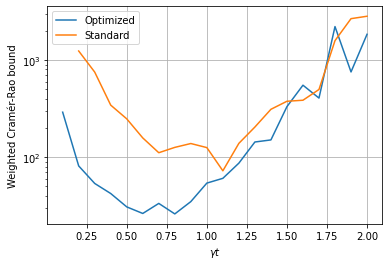

In [ ]:
gammas = np.linspace(0.1, 2.0, 20)
comparison_costs = {
    "optimized": [],
    "standard": [],
}

for yt in gammas:
    comparison_costs["optimized"].append(
        cost(weights, Nansatz, params, yt, mod, nwires, J, W)
    )
    comparison_costs["standard"].append(
        cost(Ramsey_weights, Nansatz, params, yt, mod, nwires, J, W)
    )

import matplotlib.pyplot as plt

plt.semilogy(gammas, comparison_costs["optimized"], label="Optimized")
plt.semilogy(gammas, comparison_costs["standard"], label="Standard")
plt.xlabel(r"$\gamma t$")
plt.ylabel("Weighted Cramér-Rao bound")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(comparison_costs["optimized"])

[290.82271882362807, 81.3411037763969, 53.6965988066886, 42.284143843022946, 30.808994958451255, 26.357482629805613, 33.446614187169025, 26.07751267091382, 34.91270632001214, 54.14112814591034, 60.63701843154716, 86.90898318693942, 143.46078996497712, 150.6809339927275, 331.76848388550076, 551.3763900406736, 406.3591970603578, 2212.976307524911, 755.0241657863232, 1842.9966327629813]


## Compute SLD and RLD

In [ ]:
!pip install cvxopt 

In [ ]:
import cvxopt as cvx 
import pennylane as qml 
import numpy as np 
from numpy import outer
from numpy import trace as tr
from numpy import real as re
from numpy.linalg import inv, multi_dot, eigh, matrix_rank
from scipy.linalg import solve, block_diag, null_space, sqrtm, norm
from scipy.optimize import newton  
import itertools as iter 

In [ ]:
def vectorize(rhos):
  # return a vectorized of rhos 
  # rhos: an array of rho matrices (data)
  vec_rhos = [np.reshape(rho, (len(rho)**2,1),order='F') for rho in rhos]
  return vec_rhos

def drho(rho_f,params):  
  # Derivetive of function rho_f(params)
  # params: number of paramaters encoded in rho_f
  # rho_f must be a function call the circuit
  dp = []
  for i in range(len(params)): 
    # Parameter shift rule 
    shift = np.zeros_like(params)
    shift[i] = np.pi / 2 
    plus = rho_f(params + shift)
    minus = rho_f(params - shift)
    dp.append(0.5 * (plus - minus))
  return dp 

In [ ]:
def inv_M(rho, epsilon = 10e-10): 
  # return inverse matrix M 
  # M = rho.trans()*I + I*rho.conj()
  # rho: input (data)
  d = len(rho)
  M = np.kron(rho.T, np.identity(d)) + np.kron(np.identity(d), rho)
  return inv(M + np.eye(len(M)) * epsilon)

def inv_R(rho, epsilon = 10e-10):
  # return inverse matrix R 
  # R = I*rho.conj()
  # rho: input (data)
  d = len(rho)
  R = np.kron(np.identity(d), rho)
  return inv(R + np.eye(len(R)) * epsilon)    

def sld_qfim(rho, drhos): 
  # return SLD_QFIM
  # rho: rho matrix (data)
  # drhos: derivative of rho (data)

  d = len(drhos) # number of paramaters
  H = np.zeros((d,d), dtype = complex)
  invM = inv_M(rho)
  vec_drhos = vectorize(drhos)

  for i in range(d):
    for j in range(d): 
      H[i,j] = 2*multi_dot([np.conjugate(vec_drhos[i]).T, invM, vec_drhos[j]]) 
  return H 

# RLD QFIM 
def rld_qfim(rho, drhos): 
  # return RLD_QFIM
  # rho: (data)
  # drhos: (data)
  # invR = inverse rho (data)

  d = len(drhos) # number of estimated parameters 
  R = np.zeros((d,d), dtype = complex)
  invR = inv_R(rho)
  vec_drhos = vectorize(drhos)
 
  for i in range(d):
    for j in range(d): 
      R[i,j] = multi_dot([np.conjugate(vec_drhos[i]).T, invR, vec_drhos[j]]) 
  return R

# Quantum bounds
def sld_bound(rho, drhos, W):
  # return the SLD bound
  # rho: (data)
  # drhos: derivative of rho (data)
  # W: W matrix

  SLD = sld_qfim(rho, drhos)
  return np.trace(W @ inv(SLD + np.eye(len(SLD)) * 10e-10))

def rld_bound(rho, drhos, W):
  # return the RLD bound
  # rho: (data)
  # drhos: derivative of rho (data)
  # W: W matrix

  RLD = rld_qfim(rho, drhos)
  invRLD = inv(RLD + np.eye(len(SLD)) * 10e-10)
  R1 = np.trace(W @ np.real(invRLD))
  R2 = norm(multi_dot([sqrtm(W), np.imag(invRLD),sqrtm(W)])) 

  return R1 + R2 

#test code

In [ ]:
# Test code for GHZ
n = 3
wires = list(range(0, n))
devi = qml.device("default.mixed", wires=n, shots=1000)

@qml.qnode(devi)
def rho_func(params): 
    qml.Hadamard(wires=0)
    for i in range(1,n):
      qml.CNOT(wires = [0,i])
    for i in range(n):
      qml.RZ(params[i], wires=[i])  
      qml.RX(params[i], wires=[i]) 
      qml.RZ(params[i], wires=[i]) 
    return qml.state()

thetas = np.array([np.pi/6, np.pi/4, -np.pi/6])

drhos = drho(rho_func,thetas)
rho_data = rho_func(thetas)

print(sld_bound(rho_data, drhos, W))
print(rld_bound(rho_data, drhos, W))


(1.5145688376248894e-08-2.9305859859284306e-17j)
2.831858446375162e-08


In [ ]:
# Test with noisy model above

# save rho_data for later use
@qml.qnode(dev)
def rho_cir(params,weights = weights, Nansatz = Nansatz, yt = yt, mod = mod, nwires = nwires):
  #Nansatz: number-ansatz-parameters
  ansatz(weights[:Nansatz])
  encoding(yt, mod, params, nwires)
  return qml.state()

rho_data = rho_cir(params)
drhos = drho(rho_cir,params)

W = np.eye(3)
print(sld_bound(rho_data, drhos, W))
print(rld_bound(rho_data, drhos, W))

(18.201814256551785-1.2873026584746309e-15j)
11.015051514654969
